### Convolutional Neural Network for CIFAR-10

In [49]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from Cifar10 import Cifar10
import helpers
import random

In [50]:
# device configuration
# device = torch.device('mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

print(f'Using device {device}')

# consitency in training
torch.manual_seed(1234)
random.seed(1234)

Using device cuda


In [51]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = Cifar10(train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = Cifar10(train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [52]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Net2(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layer = nn.Sequential(
             nn.Conv2d(3, 32, 3),
             nn.Conv2d(32, 64, 3),
             nn.MaxPool2d(2,2),
             nn.Conv2d(64, 128, 3),
             nn.MaxPool2d(2, 2),
             nn.Conv2d(128, 256, 3),
             nn.MaxPool2d(2,2),
        )
        
        self.ff_layer = nn.Sequential(
            nn.Linear(1024, 640),
            nn.ReLU(inplace=True),
            nn.Linear(640, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.ff_layer(x)
        return x

class Net3(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layer = nn.Sequential(
             nn.Conv2d(3, 16, 3),
             nn.Conv2d(16, 64, 3),
             nn.AvgPool2d(2,2),
             nn.Conv2d(64, 128, 3),
             nn.MaxPool2d(2, 2),
             nn.Conv2d(128, 256, 3),
             nn.MaxPool2d(2,2),
        )
        
        self.ff_layer = nn.Sequential(
            nn.Linear(1024, 640),
            nn.ReLU(inplace=True),
            nn.Linear(640, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.ff_layer(x)
        return x




In [34]:
num_epochs = 3

# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

param_options = [
    (optim.SGD, {'lr':0.001, 'momentum':0.9}, Net1, 'SGD Net1'),
    (optim.SGD, {'lr':0.001, 'momentum':0.9}, Net2, 'SGD Net2'),
    (optim.SGD, {'lr':0.001, 'momentum':0.9}, Net3, 'SGD Net3'),
    (optim.Adam, {'lr':0.001}, Net1, 'Adam Net1'),
    (optim.Adam, {'lr':0.001}, Net2, 'Adam Net2'),
    (optim.Adam, {'lr':0.001}, Net3, 'Adam Net3'),
]

metrics = []
for opt, kwargs, Net, label in param_options:
    net = Net().to(device)
    # loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = opt(net.parameters(), **kwargs)
    loss_vals, tr_acc, te_acc  = helpers.train_model(net, trainloader, testloader, device, criterion, optimizer, num_epochs)

    metrics.append((loss_vals, tr_acc, te_acc, label))

starting training
[1,  2000] loss: 2.173 tr acc: 0.271 te acc: 0.266
[1,  4000] loss: 1.893 tr acc: 0.323 te acc: 0.322
[1,  6000] loss: 1.716 tr acc: 0.407 te acc: 0.405
[1,  8000] loss: 1.607 tr acc: 0.457 te acc: 0.457
[1, 10000] loss: 1.529 tr acc: 0.462 te acc: 0.458
[2,  2000] loss: 1.467 tr acc: 0.505 te acc: 0.493
[2,  4000] loss: 1.404 tr acc: 0.499 te acc: 0.486
[2,  6000] loss: 1.379 tr acc: 0.514 te acc: 0.495
[2,  8000] loss: 1.344 tr acc: 0.503 te acc: 0.491
[2, 10000] loss: 1.306 tr acc: 0.578 te acc: 0.556
[3,  2000] loss: 1.243 tr acc: 0.545 te acc: 0.525
[3,  4000] loss: 1.249 tr acc: 0.590 te acc: 0.561
[3,  6000] loss: 1.217 tr acc: 0.604 te acc: 0.568
[3,  8000] loss: 1.207 tr acc: 0.605 te acc: 0.577
[3, 10000] loss: 1.226 tr acc: 0.555 te acc: 0.528
Finished Training
starting training
[1,  2000] loss: 2.126 tr acc: 0.306 te acc: 0.306
[1,  4000] loss: 1.781 tr acc: 0.386 te acc: 0.387
[1,  6000] loss: 1.581 tr acc: 0.457 te acc: 0.453
[1,  8000] loss: 1.466 tr ac

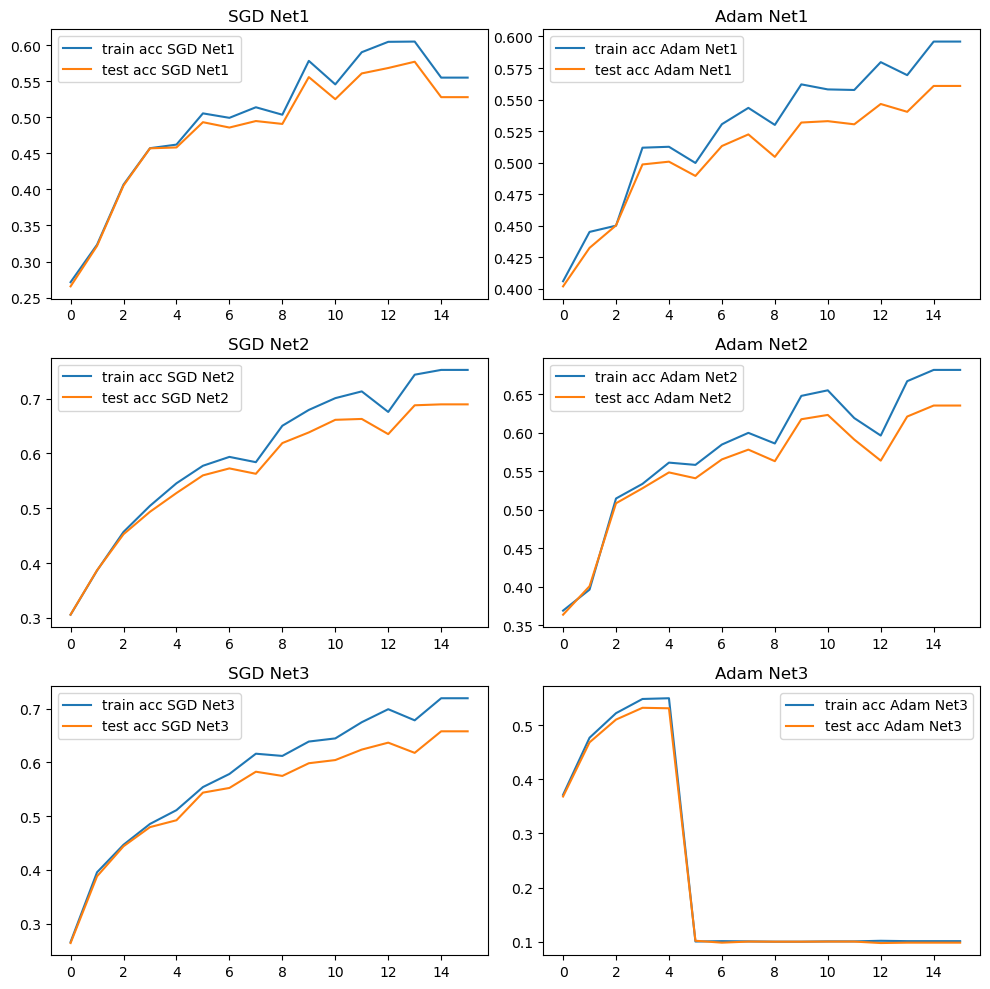

[([2.1730478204488755,
   1.8928903277516365,
   1.7162614613473415,
   1.6073968781232835,
   1.5286704963594675,
   1.4665121409371495,
   1.403896660387516,
   1.3785967994481325,
   1.3436045818775892,
   1.305817119039595,
   1.2430742075666785,
   1.2485161770135165,
   1.2167545849308372,
   1.2068133254423739,
   1.2259328517615795,
   0.0],
  [0.2714,
   0.323325,
   0.4066,
   0.457075,
   0.46205,
   0.505325,
   0.49915,
   0.5138,
   0.50345,
   0.5781,
   0.5455,
   0.5901,
   0.604475,
   0.604825,
   0.554875,
   0.554875],
  [0.2656,
   0.3217,
   0.4053,
   0.4569,
   0.4581,
   0.4931,
   0.4857,
   0.4947,
   0.4907,
   0.5556,
   0.525,
   0.5607,
   0.5682,
   0.5769,
   0.5278,
   0.5278],
  'SGD Net1'),
 ([2.125667357712984,
   1.7807545824348927,
   1.5813671719133855,
   1.465566455118358,
   1.3794890927523376,
   1.2855425187535583,
   1.2164752675406634,
   1.1835204374194146,
   1.110253740196582,
   1.0501886914651841,
   0.9038958728453145,
   0.91821504

In [39]:
fig, axes = plt.subplots(3, 2, figsize=(10,10))


for idx, (loss_vals, tr_acc, te_acc, label) in enumerate(metrics):
    # ax1, ax2 = axes[idx]
    ax = axes[idx%3][idx//3]
    # ax1.plot(range(len(loss_vals)), loss_vals, label=f'Loss {label}')
    ax.plot(range(len(loss_vals)), tr_acc, label=f'train acc {label}')
    ax.plot(range(len(loss_vals)), te_acc, label=f'test acc {label}')

    ax.set_title(label)
    ax.legend()
    # ax2.legend()

plt.tight_layout()
plt.show()

metrics

In [41]:
net = Net2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_vals, tr_acc, te_acc  = helpers.train_model(net, trainloader, testloader, device, criterion, optimizer, num_epochs)


starting training
[1,  2000] loss: 2.190 tr acc: 0.265 te acc: 0.264
[1,  4000] loss: 1.816 tr acc: 0.401 te acc: 0.394
[1,  6000] loss: 1.589 tr acc: 0.474 te acc: 0.465
[1,  8000] loss: 1.494 tr acc: 0.472 te acc: 0.465
[1, 10000] loss: 1.383 tr acc: 0.541 te acc: 0.534
[2,  2000] loss: 1.281 tr acc: 0.531 te acc: 0.514
[2,  4000] loss: 1.228 tr acc: 0.613 te acc: 0.587
[2,  6000] loss: 1.162 tr acc: 0.627 te acc: 0.593
[2,  8000] loss: 1.103 tr acc: 0.664 te acc: 0.626
[2, 10000] loss: 1.053 tr acc: 0.671 te acc: 0.636
[3,  2000] loss: 0.946 tr acc: 0.695 te acc: 0.650
[3,  4000] loss: 0.915 tr acc: 0.721 te acc: 0.661
[3,  6000] loss: 0.890 tr acc: 0.712 te acc: 0.651
[3,  8000] loss: 0.896 tr acc: 0.713 te acc: 0.660
[3, 10000] loss: 0.865 tr acc: 0.742 te acc: 0.673
Finished Training


In [58]:
torch.save(net.state_dict(), './CNN_net.pth')

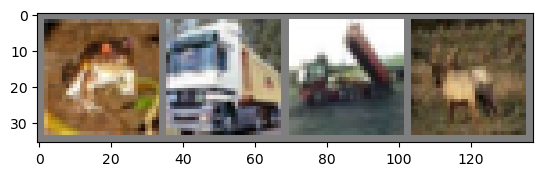

GroundTruth:  frog  truck truck deer 
Predicted:  frog  truck truck deer 


In [60]:
net = Net2()
net.load_state_dict(torch.load('./CNN_net.pth'))
net.eval()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)

for images, labels in dataiter:
    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                                for j in range(4)))
